In [1]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from qiskit import IBMQ, Aer, QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import TwoLocal, ZFeatureMap, ZZFeatureMap
from qiskit.utils import QuantumInstance
from qiskit.visualization import plot_error_map
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit_machine_learning.neural_networks import CircuitQNN, OpflowQNN
from qiskit_machine_learning.utils.loss_functions import CrossEntropyLoss, L2Loss
from sklearn import preprocessing, svm
from sklearn.decomposition import PCA

os.environ["QISKIT_IN_PARALLEL"] = "TRUE"

In [2]:
SEED = 2508
random.seed(SEED)

In [3]:
IBMQ.save_account('2cbef8bb13319e6e7b13d35550126b4a09482f9cecda1c78deaa1295cbc8b3a87e24697d65a53b05c004ab6882111fb2b721fc617f3f900abe3924f16b83c71b')
IBMQ.load_account()
provider = IBMQ.get_provider()
print(provider.backends())

configrc.store_credentials:WARNING:2022-09-16 18:23:19,853: Credentials already present. Set overwrite=True to overwrite.


[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQSimulator('simulator_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_manila') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibm_nairobi') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibm_oslo') from IBMQ(hub='ibm-q', group='open', project='main')>]


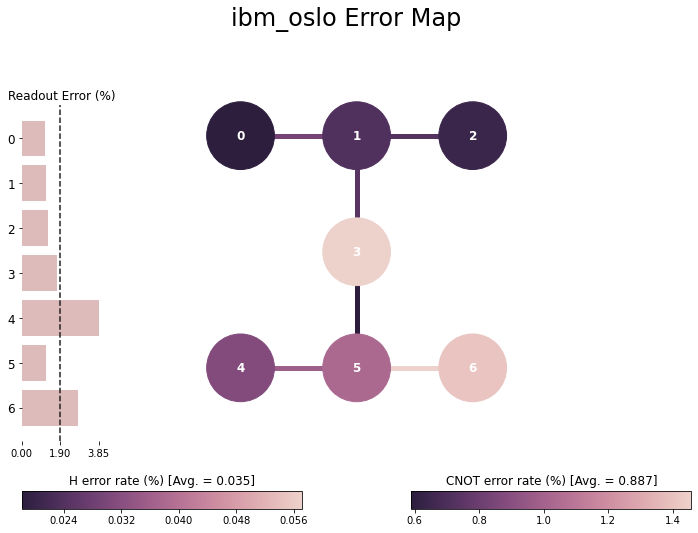

In [4]:
ibmq_jakarta = provider.get_backend("ibm_oslo")
plot_error_map(ibmq_jakarta)

# 1. Prepare (New) Dataset

**Dataset Information:**
* Total examples: 20,468 -- Dimensions: 112
* PCA down to: **4** dimensions
* Train set size: **100 (adjustable in cell below)**
* Test set size: **2,000 (adjustable in cell below)**

**Variables Information:**
* `x_train` [np.array] stores the train examples -- shape: (Train set size, 4)
* `y_train` [np.array] stores the train labels -- shape: (Train set size,)
* `x_test` [np.array] stores the test examples -- shape: (Test set size, 4)
* `y_test` [np.array] stores the train labels -- shape: (Test set size,)

**Note:** Run all cells in this section to generate the dataset variables

In [5]:
# set number of training and test example ---------------
n_examples = 100
n_test = 2000

In [6]:
# change the directory to the correct one on your machine
datafile = pd.read_csv("data/fraud_detection_bank_dataset.csv")
data = datafile.to_numpy()
datafile.head()

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,...,col_103,col_104,col_105,col_106,col_107,col_108,col_109,col_110,col_111,targets
0,9,1354,0,18,0,1,7,9,0,0,...,0,0,0,1,1,0,0,0,49,1
1,0,239,0,1,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,55,1
2,0,260,0,4,0,3,6,0,0,0,...,0,0,0,1,1,0,0,0,56,1
3,17,682,0,1,0,0,8,17,0,0,...,0,1,0,1,1,0,0,0,65,1
4,1,540,0,2,0,1,7,1,0,0,...,0,0,0,1,1,0,0,0,175,1


In [7]:
# Scale the features in the dataset, prior to PCA
X_data = data[:, :-1]
X_data = preprocessing.StandardScaler().fit_transform(X_data)

In [8]:
# PCA to reduce the number of features
pca = PCA(n_components=4, random_state=SEED)
X_pca = pca.fit_transform(X_data)
# Scale the features in the dataset, post PCA
X_pca = preprocessing.StandardScaler().fit_transform(X_pca)

In [9]:
n_class_train = int(n_examples / 2)
n_class_test = int(n_test / 2)

# 0 --> 3000 (pos train) ; 3000 --> 5438 (pos test)
# 5438 --> 18000 (neg train) ; 18000 --> 20468 (neg test)
rand_pos_ind = random.sample(range(0, 3000), n_class_train)
rand_neg_ind = random.sample(range(5438, 18000), n_class_train)
x_train = np.concatenate((X_pca[rand_pos_ind], X_pca[rand_neg_ind]))
y_train = (
    np.concatenate((np.ones((n_class_train, 1)), np.zeros((n_class_train, 1))))
    .astype(int)
    .reshape(
        n_examples,
    )
)

rand_pos_ind = random.sample(range(3000, 5438), n_class_test)
rand_neg_ind = random.sample(range(18000, 20468), n_class_test)
x_test = np.concatenate((X_pca[rand_pos_ind], X_pca[rand_neg_ind]))
y_test = (
    np.concatenate((np.ones((n_class_test, 1)), np.zeros((n_class_test, 1))))
    .astype(int)
    .reshape(
        n_test,
    )
)

# compatibility with previous implementation
x_train_norm = x_train
x_test_norm = x_test

# 2. VQC from scratch

## 2.1. Prepare encoders and ansatz

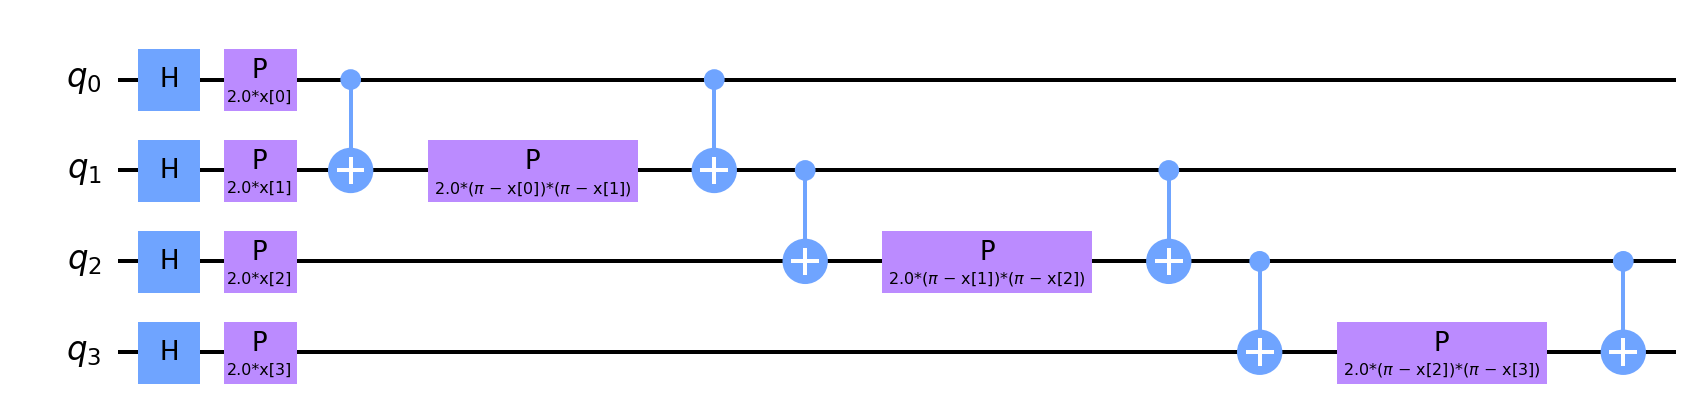

In [10]:
def get_zz_feature_map(feature_dim, feature_map_rep, ent):
    return ZZFeatureMap(
        feature_dimension=feature_dim, reps=feature_map_rep, entanglement=ent
    )


feature_dim = 4
fmap_zz = get_zz_feature_map(feature_dim, 1, "linear")
fmap_zz.decompose().draw("mpl", scale=2)

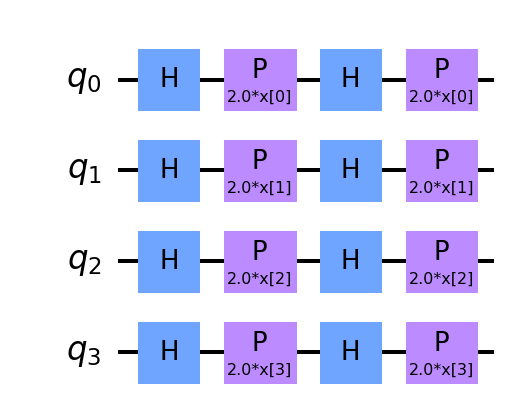

In [11]:
def get_z_feature_map(feature_dim, feature_map_rep):
    return ZFeatureMap(feature_dimension=feature_dim, reps=feature_map_rep)


fmap_z = get_z_feature_map(feature_dim, 2)
fmap_z.decompose().draw("mpl", scale=2)

x, ['x[0]', 'x[1]', 'x[2]', 'x[3]']


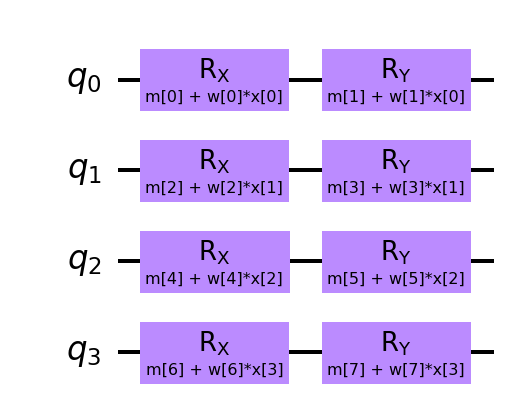

In [12]:
# Define angle embedding with weights
def get_angle_embedding(nb_features, repeat=1):
    x_params = ParameterVector("x", nb_features)
    weight_params = ParameterVector("w", 2 * nb_features * repeat)
    rotation_params = ParameterVector("m", 2 * nb_features * repeat)

    model_params = list(rotation_params) + list(weight_params)

    qc = QuantumCircuit(nb_features)
    for j in range(repeat):
        for i in range(nb_features):
            qc.rx(
                x_params[i] * weight_params[2 * i + 2 * nb_features * j]
                + rotation_params[2 * i + 2 * nb_features * j],
                i,
            )
            qc.ry(
                x_params[i] * weight_params[2 * i + 2 * nb_features * j + 1]
                + rotation_params[2 * i + 2 * nb_features * j + 1],
                i,
            )

    return qc, x_params, model_params


repeat = 1
angle_embedding, x_params, m_params = get_angle_embedding(feature_dim, repeat)
print(x_params)
angle_embedding.draw("mpl", scale=2)

In [13]:
# Define function(s) to generate the encoder circuit
# TODO: implement different designs for data encoding (one function for each)
def encoder_circuit_1(data_x, _):
    """
    Args:
        data_x [np.array] : one data example
        (...)
    Returns:
        encoder_circuit [QuantumCircuit] : encoder circuit for input data example
    """
    encoder_circuit = None
    return encoder_circuit


## 2.2. Prepare Ansatz

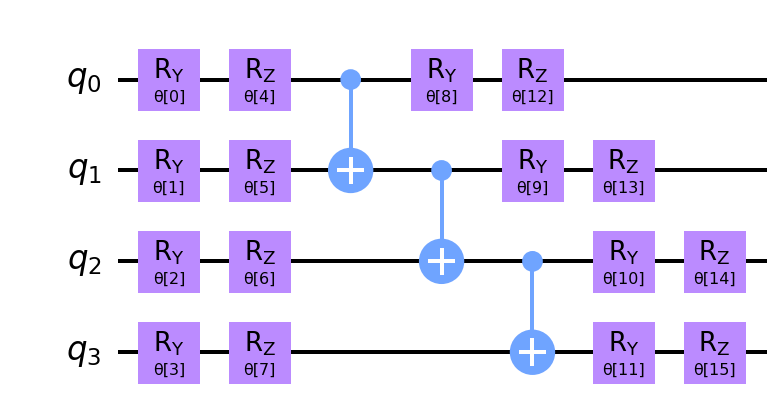

In [14]:
def get_two_locals(feature_dim, rotations, var_form_rep, ent):
    return TwoLocal(
        num_qubits=feature_dim,
        rotation_blocks=rotations,
        entanglement_blocks="cx",
        entanglement=ent,
        reps=var_form_rep,
    )


ansatz_tl = get_two_locals(feature_dim, ["ry", "rz"], 1, "linear")
ansatz_tl.decompose().draw("mpl", scale=2)

In [15]:
# Define function(s) to generate the ansatz
# TODO: implement different ansatz designs (one function for each)
def ansatz_1(n_qubits, _):
    """
    Args:
        n_qubits [int] : number of qubits in the circuit
        (...other necessary args -- e.g., n_layers)
    Returns:
        ansatz [QuantumCircuit] : parameterized ansatz circuit
        ansatz_params [ParameterVector] : parameter vector of the ansatz
    """
    ansatz = None
    ansatz_params = None
    return ansatz, ansatz_params


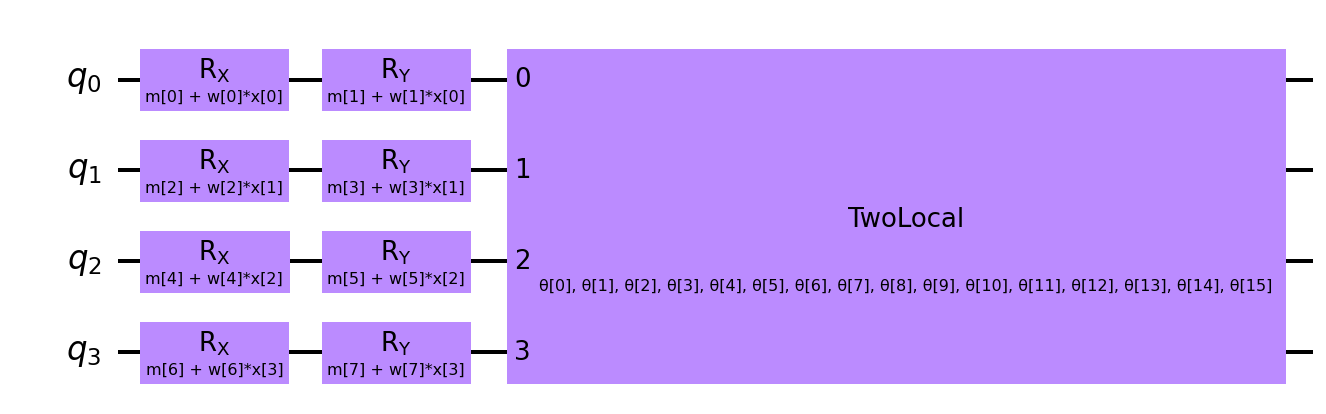

In [16]:
var_circuit = angle_embedding.compose(ansatz_tl)
var_circuit.draw("mpl", scale=2)

In [17]:
# TODO: Define function to generate all data encoder circuits (one for each example in the dataset)
# Preparing and cache all encoder circuits to concatenate with ansatz later
def get_all_encoders(data_mat, encoder_func, _):
    """
    Args:
        data_mat [np.array] : of shape (n_samples,n_features) -- matrix containing all examples
        encoder_func [function] : callable to generate encoder circuit (e.g., encoder_circuit_1)
        (...)
    Returns:
        all_encoders [list(QuantumCircuit)] : list of all encoder circuits (one for each example)
    """
    all_encoders = []
    # pseudo-code: for 'example' in 'data_mat': all_encoders.append(encoder_func('example'))
    return all_encoders


In [18]:
# TODO: Define function to generate all VQC circuits (one for each example)
def get_all_circuits(all_encoders, ansatz_func, _):
    """
    Args:
        all_encoders [list(QuantumCircuit)] : list of all encoder circuits (one for each example)
        ansatz_func [function] : callable to generate ansatz circuit (e.g., ansatz_1)
        (...)
    Returns:
        all_circuits [list(QuantumCircuit)] : list of all VQC circuits (one for each example)
    """
    all_circuits = []
    return all_circuits


In [19]:
# Create a quantum instance to wrap the execution of circuits
qinstVQC = QuantumInstance(Aer.get_backend("statevector_simulator"))

In [20]:
# TODO: Define function to calculate target values (can be expectation value or sampling probability)
def get_all_target_vals(all_results, _):
    """
    Args:
        all_results [Result] : output wrapper of all results from executing the VQC circuits
        (...)
    Returns:
        target_val [list(float)] : target values for classification (e.g., expectation value), one for each example
    """
    target_vals = []
    return target_vals


In [21]:
# TODO: Define function to calculate cost function given all target vals (there can be multiple designs for cost function)
def calculate_cost_function(target_vals, true_labels, _):
    """
    Args:
        target_vals [list(float)] : target values for classification (e.g., expectation value), one for each example
        true_labels [np.array] : vector containing true labels for each example (0 or 1)
        (...)
    Returns:
        cost [float] : total cost for current instance
    """
    cost = 0
    return cost


## 2.3 Prepare measurement

In [22]:
# for multi-class problem this works
def parity(x, num_classes):
    return f"{x:b}".count("1") % num_classes


# for multi-class problem this needs to be changed
def one_qubit_binary(x):
    return x % 2


# 3. VQC using Qiskit QNN Classes

In [23]:
qasm_sim = Aer.get_backend("qasm_simulator")
qinst_qasm = QuantumInstance(qasm_sim, 2048)

## 3.1. Circuit QNN

In [24]:
num_classes = 2
qnn = CircuitQNN(
    circuit=var_circuit,
    # input_params=fmap_z.parameters,
    # input_params=fmap_zz.parameters,  # if your embedding strategy is not a parametrized circuit
    input_params=x_params,  # (e.g. amplitude encoding) you will have to do some extra work!
    # weight_params=ansatz_tl.parameters,  # if you train your embedding as well, the trainable
    weight_params=list(ansatz_tl.parameters)
    + list(m_params),  # parameters of the embedding must be added
    interpret=one_qubit_binary,
    output_shape=num_classes,
    gradient=None,
    quantum_instance=qinst_qasm,
)

In [25]:
# to run on hardware
phys_qubits = [3, 4, 5, 6]
N_shots = 2048
qinst_hardware = QuantumInstance(ibmq_jakarta
     ,shots=N_shots, initial_layout=phys_qubits
)

In [26]:
qnn_hardware = CircuitQNN(
    circuit=var_circuit,
    # input_params=fmap_z.parameters,
    # input_params=fmap_zz.parameters,  # if your embedding strategy is not a parametrized circuit
    input_params=x_params,  # (e.g. amplitude encoding) you will have to do some extra work!
    weight_params=list(ansatz_tl.parameters)
    + list(m_params),  # if you train your embedding as well, the trainable
    # parameters of the embedding must be added
    interpret=one_qubit_binary,
    output_shape=num_classes,
    gradient=None,
    quantum_instance=qinst_hardware,
)

### Forward pass

In [27]:
# The result of the neural network of the shape (output_shape).
weights = np.random.random(len(list(ansatz_tl.parameters) + list(m_params)))

output = qnn.forward(x_train[1], weights)
print(output.shape)
output

(1, 2)


array([[0.59863281, 0.40136719]])

### Backward pass

In [28]:
_, update = qnn.backward(x_train[0], weights)
print(update)
print(update.shape)

[[[-0.43432617  0.00805664  0.00195312  0.00830078  0.04174805
   -0.02807617  0.00585937  0.00317383 -0.30053711  0.00634766
   -0.00610352 -0.00610352  0.00268555 -0.01538086  0.00512695
    0.00756836 -0.04467773 -0.42700195  0.02758789  0.01538086
    0.01635742 -0.00146484  0.00170898 -0.00219727  0.00476534
    0.06247501  0.02132979 -0.00097943 -0.00156059 -0.00078029
    0.00776801 -0.00057118]
  [ 0.43432617 -0.00805664 -0.00195313 -0.00830078 -0.04174805
    0.02807617 -0.00585938 -0.00317383  0.30053711 -0.00634766
    0.00610352  0.00610352 -0.00268555  0.01538086 -0.00512695
   -0.00756836  0.04467773  0.42700195 -0.02758789 -0.01538086
   -0.01635742  0.00146484 -0.00170898  0.00219727 -0.00476534
   -0.06247501 -0.02132979  0.00097943  0.00156059  0.00078029
   -0.00776801  0.00057118]]]
(1, 2, 32)


### 3.1.1. Prepare encoder, ansatz, and interpreter

In [29]:
def get_one_hot_encoding(y):
    unique_labels = np.unique(y, axis=0)
    y_one_hot = [
        (np.eye(len(unique_labels))[np.where(unique_labels == y_i)]).reshape(
            len(unique_labels)
        )
        for y_i in y
    ]

    return np.array(y_one_hot)


y_train_1h = get_one_hot_encoding(y_train)
y_test_1h = get_one_hot_encoding(y_test)

In [30]:
def callback(nfev, params, fval, stepsize, accepted=None):
    """
    Can be used for SPSA and GradientDescent optimizers
    nfev: the number of function evals
    params: the current parameters
    fval: the current function value
    stepsize: size of the update step
    accepted: whether the step was accepted (not used for )
    """
    global loss_recorder

    loss_recorder.append(fval)
    print(f"{nfev} - {fval}")

### 3.1.2. Training Implementation

In [31]:
from qiskit.algorithms.optimizers import ADAM, COBYLA, SLSQP, SPSA

max_itr = 50
spsa_opt = SPSA(maxiter=max_itr, callback=callback)
loss_recorder = []
initial_point = np.random.random((len(list(ansatz_tl.parameters) + list(m_params)),))
vqc = NeuralNetworkClassifier(
    neural_network=qnn,
    loss=CrossEntropyLoss(),  # log of ...
    one_hot=True,
    optimizer=spsa_opt,
    initial_point=initial_point,
)

x_train_norm = np.array(
    [x / np.linalg.norm(x) for x in x_train]
)  # normalizing or not ... can depend on the data set you can try both
vqc = vqc.fit(x_train_norm, y_train_1h)

3 - 1.1951404163636667
6 - 1.6280121945263146
9 - 1.1844080842215727
12 - 1.2596498094502566
15 - 1.09632336573924
18 - 1.1251281923686485
21 - 1.0488707894118305
24 - 1.0056521160790826
27 - 0.9988125670948149
30 - 1.0036924900909485
33 - 0.9988848133635352
36 - 0.9607153997787197
39 - 0.9564975567180914
42 - 0.9632334107685665
45 - 0.958905005269595
48 - 0.961429854670406
51 - 0.9551584591280067
54 - 0.9512435038372992
57 - 0.9537974241693583
60 - 0.9531285684448477
63 - 0.9541251364209701
66 - 0.9454247830916118
69 - 0.9291644935478723
72 - 0.9360512558500076
75 - 0.9246676802903334
78 - 0.9267058235994735
81 - 0.9198089478456934
84 - 0.9178841759380865
87 - 0.9194831637871083
90 - 0.9161005032129677
93 - 0.9138883718438024
96 - 0.9138758256269978
99 - 0.9167992330006811
102 - 0.9160830657459513
105 - 0.9148789976368712
108 - 0.9091549161157012
111 - 0.9071080234134122
114 - 0.9098212830031163
117 - 0.9080621358530895
120 - 0.908104763379057
123 - 0.9057981134870994
126 - 0.89937186

In [ ]:
# to run on hardware
max_itr = 50
spsa_opt = SPSA(maxiter=max_itr, callback=callback)
loss_recorder = []
initial_point = np.random.random((len(list(ansatz_tl.parameters) + list(m_params)),))
vqc = NeuralNetworkClassifier(
    neural_network=qnn_hardware,
    loss=CrossEntropyLoss(),  # log of ...
    one_hot=True,
    optimizer=spsa_opt,
    initial_point=initial_point,
)

x_train_norm = np.array(
    [x / np.linalg.norm(x) for x in x_train]
)  # normalizing or not ... can depend on the data set you can try both
vqc = vqc.fit(x_train_norm, y_train_1h)

In [ ]:
score_train_norm = vqc.score(x_train_norm, y_train_1h)
print(f"Score on the normalized train set {score_train_norm}")

x_test_norm = np.array(
    [x / np.linalg.norm(x) for x in x_test]
)  # normalizing or not ... can depend on the data set you can try both
score_test_norm = vqc.score(x_test_norm, y_test_1h)
print(f"Score on the normalized test set {score_test_norm}")

In [ ]:
plt.plot(loss_recorder)

### 3.1.3. Results Discussion

## 3.2. Opflow QNN

### 3.2.1. Define measurement operator and circuit state function

In [42]:
from qiskit.opflow import StateFn, Gradient, I, Z

In [43]:
obs_parity = Z ^ feature_dim
obs_one_qubit = I ^ (feature_dim - 1) ^ Z
obs_one_qubit

PauliOp(Pauli('IIIZ'), coeff=1.0)

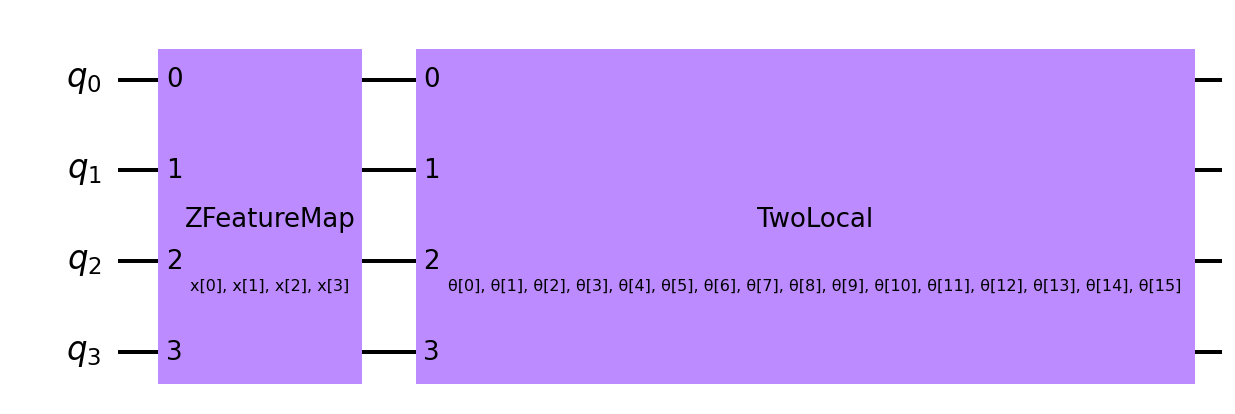

In [82]:
mymap_op = get_z_feature_map(feature_dim, 2)
var_circuit_op = mymap_op.compose(ansatz_tl)
var_circuit_op.draw("mpl", scale=2)

In [83]:
operator = ~StateFn(obs_one_qubit) @ StateFn(var_circuit_op)
operator

ComposedOp([OperatorStateFn(PauliOp(Pauli('IIIZ'), coeff=1.0), coeff=1.0, is_measurement=True), CircuitStateFn(<qiskit.circuit.library.data_preparation.z_feature_map.ZFeatureMap object at 0x0000020F9B15FC48>, coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False)

In [84]:
gradient = Gradient(grad_method="param_shift")
op_qnn = OpflowQNN(
    operator,
    # input_params=fmap_z_op.parameters,
    input_params=mymap_op.parameters,
    weight_params=ansatz_tl.parameters,
    gradient=gradient,
    quantum_instance=qinst_qasm,
)

### Forward pass

In [85]:
weights = np.random.random(len(ansatz_tl.parameters))
output = op_qnn.forward(x_train[0], weights)
print(output.shape)

(1, 1)


### Backward pass

In [86]:
_, update = op_qnn.backward(x_train[0], weights)
print(update.shape)
update

(1, 1, 16)


array([[[-0.67822266,  0.00537109, -0.00292969, -0.00097656,
          0.34814453, -0.0234375 ,  0.00439453, -0.00927734,
         -0.75439453, -0.00146484,  0.02490234,  0.0078125 ,
          0.01123047, -0.00195312, -0.00927734,  0.01757812]]])

### 3.1.2. Training Implementation

In [87]:
from qiskit.algorithms.optimizers import GradientDescent

In [88]:
y_train_pm = np.array([-1 if y==0 else y for y in y_train])
y_test_pm = np.array([-1 if y==0 else y for y in y_test])
y_train.shape

(100,)

In [89]:
max_itr = 50
gd_opt = GradientDescent(maxiter=max_itr, callback=callback)
loss_recorder = []
initial_point = np.random.random((len(ansatz_tl.parameters),))
op_vqc = NeuralNetworkClassifier(
    neural_network=op_qnn,
    loss=L2Loss(),
    one_hot=False,
    optimizer=gd_opt,
    initial_point=initial_point,
)

op_vqc = op_vqc.fit(x_train, y_train_pm)

1 - 1.224287567138672
2 - 1.2125838565826417
3 - 1.1953830337524414
4 - 1.1845074081420899
5 - 1.1858576679229735
6 - 1.173168363571167
7 - 1.1670312309265136
8 - 1.1567787075042724
9 - 1.1542248058319091
10 - 1.143143253326416
11 - 1.1368250751495361
12 - 1.136270751953125
13 - 1.1263054180145264
14 - 1.1141995334625243
15 - 1.1134985637664796
16 - 1.1041170120239259
17 - 1.100945520401001
18 - 1.0901220989227296
19 - 1.0867064571380616
20 - 1.083990306854248
21 - 1.0843643474578857
22 - 1.072239761352539
23 - 1.0669044208526612
24 - 1.0597650051116942
25 - 1.0681822490692139
26 - 1.0540321254730225
27 - 1.0508317279815673
28 - 1.0484849643707275
29 - 1.0474994564056397
30 - 1.0401480197906494
31 - 1.0439655780792236
32 - 1.025972557067871
33 - 1.0402096557617186
34 - 1.037293872833252
35 - 1.0355580139160157
36 - 1.0265463161468507
37 - 1.0221664428710937
38 - 1.0338868713378906
39 - 1.0303220081329345
40 - 1.0205224227905274
41 - 1.019805326461792
42 - 1.0234424877166748
43 - 1.0099

In [90]:
score_train = op_vqc.score(x_train, y_train_pm)
score_test = op_vqc.score(x_test, y_test_pm)
print(f"Score on the train set {score_train}")
print(f"Score on the test set {score_test}")

Score on the train set 0.52
Score on the test set 0.5315


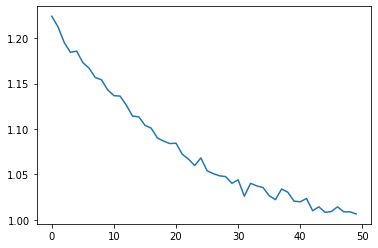

In [92]:
plt.plot(loss_recorder)

### 3.1.3. Results Discussion

# 4. Quantum Support Vector Machine

## 4.1. Define feature map(s) (kernel)

In [93]:
qinst_kernel = QuantumInstance(backend=Aer.get_backend("statevector_simulator"))

In [94]:
# ZZ-featureMap
def ZZ_kernel(
    feature_dim, reps, quantum_instance, entanglement="linear", insert_barriers=False
):
    ZZ_map = ZZFeatureMap(
        feature_dimension=feature_dim,
        reps=reps,
        entanglement=entanglement,
        insert_barriers=insert_barriers,
    )
    ZZ_kernel = QuantumKernel(ZZ_map, quantum_instance=quantum_instance)
    return ZZ_kernel

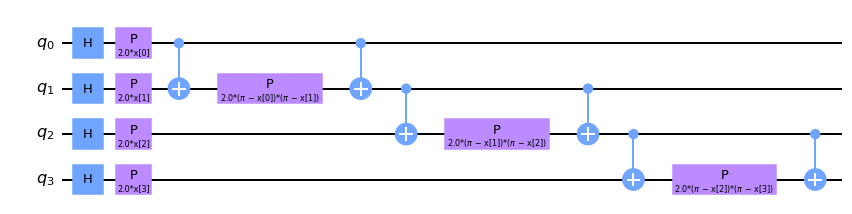

In [95]:
kernel = ZZ_kernel(feature_dim, reps=1, quantum_instance=qinst_kernel)
kernel.feature_map.decompose().draw("mpl")

In [96]:
# custom kernel inspired by Xiaoran's design, with linear entanglement
def custom_kernel(feature_dim, reps, quantum_instance, insert_barriers=False):
    qc = QuantumCircuit(feature_dim)
    data_params = ParameterVector("x", feature_dim)
    for layer in range(reps):
        for i in range(feature_dim):
            qc.ry(data_params[i], i)
            qc.rz(data_params[i], i)
        for i in range(feature_dim - 1):
            qc.cx(i, i + 1)
        if insert_barriers:
            qc.barrier()
    kernel = QuantumKernel(feature_map=qc, quantum_instance=quantum_instance)
    return kernel

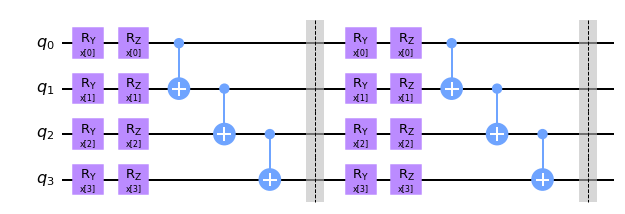

In [97]:
my_kernel = custom_kernel(
    feature_dim=feature_dim, reps=2, quantum_instance=qinst_kernel, insert_barriers=True
)
my_kernel.feature_map.draw("mpl")

## 4.2. Training Implementation (using sci-kit's SVC class)

### 4.2.1. Training with ZZ-FeatureMap

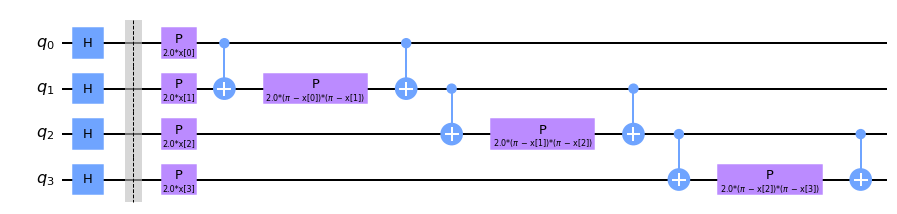

In [98]:
kernel_ZZ = ZZ_kernel(
    feature_dim=feature_dim, reps=1, quantum_instance=qinst_kernel, insert_barriers=True
)
display(kernel_ZZ.feature_map.decompose().draw("mpl"))

In [99]:
qclf_ZZ = svm.SVC(kernel=kernel_ZZ.evaluate)

In [100]:
qclf_ZZ.fit(x_train_norm, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale',
    kernel=<bound method QuantumKernel.evaluate of <qiskit_machine_learning.kernels.quantum_kernel.QuantumKernel object at 0x0000020FA93F0808>>,
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [101]:
print(f"Training accuracy: {qclf_ZZ.score(x_train_norm,y_train)}")

Training accuracy: 0.81


In [102]:
print(f"Test accuracy: {qclf_ZZ.score(x_test_norm,y_test):.3f}")

Test accuracy: 0.515


### 4.2.2. Training with custom feature map

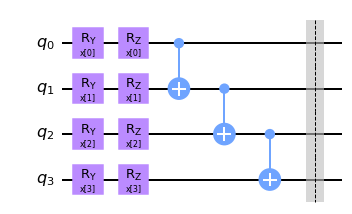

In [64]:
kernel_custom = custom_kernel(
    feature_dim=feature_dim, reps=1, quantum_instance=qinst_kernel, insert_barriers=True
)
display(kernel_custom.feature_map.draw("mpl"))

In [65]:
qclf_custom = svm.SVC(kernel=kernel_custom.evaluate)

In [66]:
qclf_custom.fit(x_train_norm, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale',
    kernel=<bound method QuantumKernel.evaluate of <qiskit_machine_learning.kernels.quantum_kernel.QuantumKernel object at 0x0000020FA69F4788>>,
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [67]:
print(f"Training accuracy: {qclf_custom.score(x_train_norm,y_train):.3f}")

Training accuracy: 0.690


In [68]:
print(f"Test accuracy: {qclf_custom.score(x_test_norm,y_test):.3f}")

Test accuracy: 0.643


## 4.3. Results Discussion

# 5. Classical Methods for Comparision

## 5.1. Classical SVM

In [69]:
clf_linear = svm.SVC(kernel="linear")
clf_linear.fit(x_train_norm, y_train)
print(
    f"Training accuracy: {clf_linear.score(x_train_norm,y_train):.3f}\n"
    + f"Testing accuracy: {clf_linear.score(x_test_norm,y_test):.3f}"
)

Training accuracy: 0.730
Testing accuracy: 0.770


In [70]:
clf_poly = svm.SVC(kernel="poly", degree=3)
clf_poly.fit(x_train_norm, y_train)
print(
    f"Training accuracy: {clf_poly.score(x_train_norm,y_train):.3f}\n"
    + f"Testing accuracy: {clf_poly.score(x_test_norm,y_test):.3f}"
)

Training accuracy: 0.740
Testing accuracy: 0.755


In [71]:
clf_rbf = svm.SVC(kernel="rbf")
clf_rbf.fit(x_train_norm, y_train)
print(
    f"Training accuracy: {clf_rbf.score(x_train_norm,y_train):.3f}\n"
    + f"Testing accuracy: {clf_rbf.score(x_test_norm,y_test):.3f}"
)

Training accuracy: 0.720
Testing accuracy: 0.649


## 5.2. Classical Neural Network

In [72]:
from sklearn.neural_network import MLPClassifier

### 5.2.1. ANN w/ 1 Hidden Layer (20) -- ReLU activation

In [73]:
clf_nn = MLPClassifier(
    solver="adam",
    hidden_layer_sizes=(20,),
    learning_rate="adaptive",
    random_state=1,
    max_iter=10000,
)
clf_nn.fit(x_train_norm, y_train)
print(f"Converged after {clf_nn.n_iter_} iterations")

Converged after 514 iterations


In [74]:
print(
    f"Training accuracy: {clf_nn.score(x_train_norm,y_train):.3f}\n"
    + f"Testing accuracy: {clf_nn.score(x_test_norm,y_test):.3f}"
)

Training accuracy: 0.740
Testing accuracy: 0.769


### 5.2.2. ANN w/ 2 Hidden Layers (20,20) -- ReLU activation

In [75]:
clf_nn_2 = MLPClassifier(
    solver="adam",
    hidden_layer_sizes=(20, 20),
    learning_rate="adaptive",
    random_state=1,
    max_iter=10000,
)
clf_nn_2.fit(x_train_norm, y_train)
print(f"Converged after {clf_nn_2.n_iter_} iterations")

Converged after 2182 iterations


In [76]:
print(
    f"Training accuracy: {clf_nn_2.score(x_train_norm,y_train):.3f}\n"
    + f"Testing accuracy: {clf_nn_2.score(x_test_norm,y_test):.3f}"
)

Training accuracy: 0.930
Testing accuracy: 0.666


### 5.2.3. ANN w/ 1 Hidden Layer (20) -- Sigmoid activation

In [77]:
clf_nn_sig = MLPClassifier(
    solver="adam",
    activation="logistic",
    hidden_layer_sizes=(20,),
    learning_rate="adaptive",
    random_state=1,
    max_iter=10000,
)
clf_nn_sig.fit(x_train_norm, y_train)
print(f"Converged after {clf_nn_sig.n_iter_} iterations")

Converged after 640 iterations


In [78]:
print(
    f"Training accuracy: {clf_nn_sig.score(x_train_norm,y_train):.3f}\n"
    + f"Testing accuracy: {clf_nn_sig.score(x_test_norm,y_test):.3f}"
)

Training accuracy: 0.710
Testing accuracy: 0.764


### 5.2.2. ANN w/ 2 Hidden Layers (20,20) -- Sigmoid activation

In [79]:
clf_nn_sig_2 = MLPClassifier(
    solver="adam",
    activation="logistic",
    hidden_layer_sizes=(20, 20),
    learning_rate="adaptive",
    random_state=1,
    max_iter=10000,
)
clf_nn_sig_2.fit(x_train_norm, y_train)
print(f"Converged after {clf_nn_sig_2.n_iter_} iterations")

Converged after 315 iterations


In [80]:
print(
    f"Training accuracy: {clf_nn_sig_2.score(x_train_norm,y_train):.3f}\n"
    + f"Testing accuracy: {clf_nn_sig_2.score(x_test_norm,y_test):.3f}"
)

Training accuracy: 0.710
Testing accuracy: 0.766
